导入需要使用的包

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
#DET 限定词， NN 名词 V 动词
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}

for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
#{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}

def  tensorFromArr(arr,arr2index):
    idxs = [arr2index[item]   for item in arr]
    return torch.tensor(idxs, dtype=torch.long)


Embedding_DIM = 6
Hidden_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [21]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        # print(f'lstm_out size: {lstm_out.size()}')
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [28]:
model = LSTMTagger(len(word_to_ix), Embedding_DIM, Hidden_DIM, len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
# 训练过程
total_loss = []
for epoch in range(300):
     for sentence, tags in training_data:
        # 梯度清零
        model.zero_grad()

        # 准备数据
        sentence_in = tensorFromArr(sentence, word_to_ix)
        targets = tensorFromArr(tags, tag_to_ix)

        # 前向传播
        tag_scores = model(sentence_in)

        # 计算损失
        loss = loss_function(tag_scores, targets)
        total_loss.append(loss.item())
        # 后向传播
        loss.backward()
        # 更新参数
        optimizer.step()

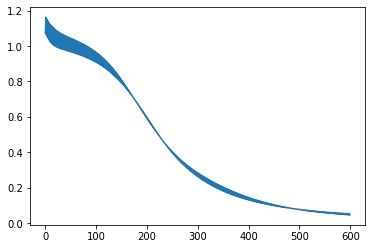

In [29]:
plt.plot(total_loss)

In [26]:
with torch.no_grad():
    inputs = tensorFromArr(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(f'target: {tensorFromArr(training_data[0][1],tag_to_ix)},predict: {tag_scores.data.max(dim=1)[1]}')

target: tensor([0, 1, 2, 0, 1]),predict: tensor([0, 1, 2, 0, 1])


In [31]:
len(total_loss)

600